In [10]:
from graphframes import GraphFrame
from pyspark.sql import SparkSession


In [11]:

spark = SparkSession.builder \
    .appName("Shortest Paths1") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.4-spark3.5-s_2.12") \
    .getOrCreate()
    

In [22]:
# Vértices
vertices = spark.createDataFrame([
    ("Times Square",),
    ("34th Street",),
    ("Herald Square",),
    ("Union Square",),
    ("Wall Street",),
    ("Fulton",),
    ("Brooklyn Bridge",),
    ("Grand Central",)
], ["id"])

# Arestas (conexões)
edges = spark.createDataFrame([
    ("Times Square", "34th Street"),
    ("34th Street", "Herald Square"),
    #("34th Street", "Grand Central"),
    ("Herald Square", "Union Square"),
    ("Union Square", "Grand Central"),
    ("Wall Street", "Fulton"),
    ("Fulton", "Brooklyn Bridge"),
    ("Brooklyn Bridge", "Grand Central")
], ["src", "dst"])

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def desenhar_grafo_subway(vertices_df, edges_df, titulo="Rede de Metrô"):
    """
    Desenha um grafo a partir de dois DataFrames PySpark: vértices e arestas.

    Parâmetros:
    - vertices_df: DataFrame com coluna 'id'
    - edges_df: DataFrame com colunas 'src' e 'dst'
    - titulo: título do gráfico (opcional)
    """
    # Coletar dados dos DataFrames para listas
    nodes = [row['id'] for row in vertices_df.select("id").collect()]
    edges = [(row['src'], row['dst']) for row in edges_df.select("src", "dst").collect()]

    # Criar o grafo direcionado
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # Layout fixo
    pos = nx.spring_layout(G, seed=42)

    # Desenhar
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=1600, node_color="lightgray", edgecolors="black")
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
    nx.draw_networkx_edges(
        G, pos,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=20,
        width=2,
        edge_color="gray"
    )

    plt.title(titulo, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

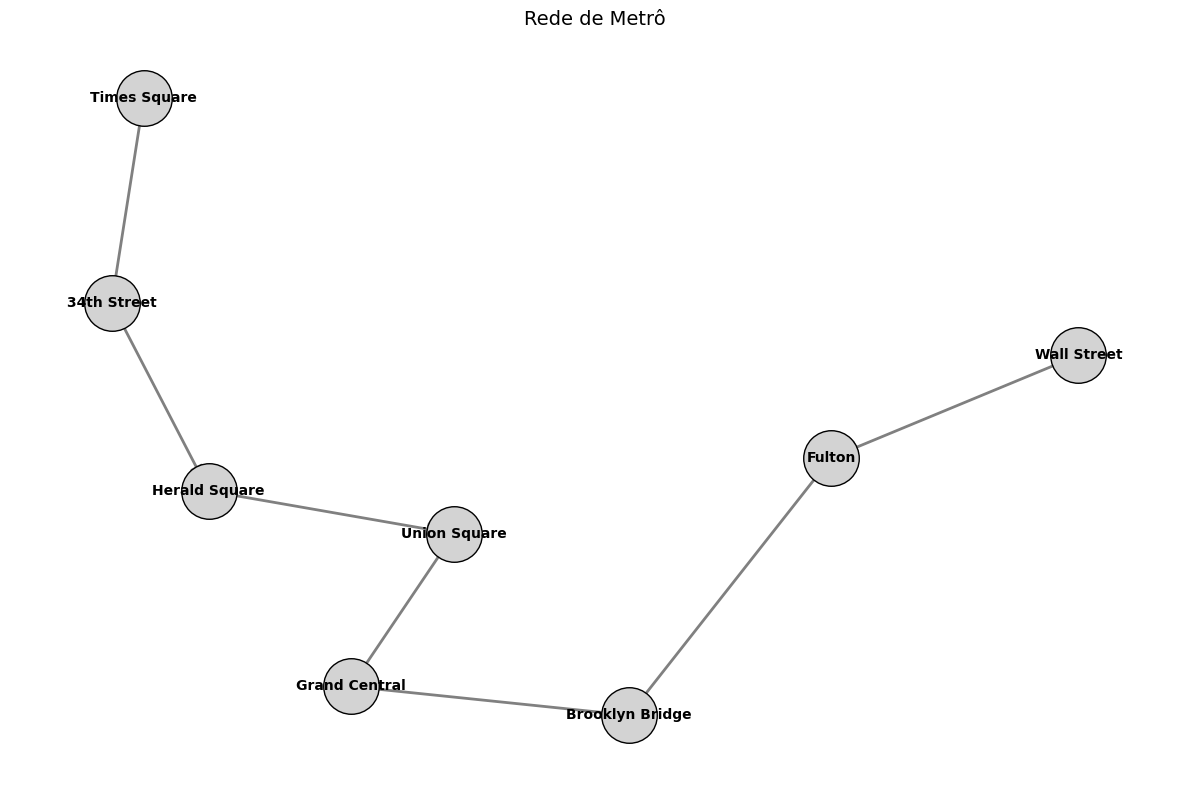

In [23]:
desenhar_grafo_subway(vertices,edges)

In [24]:
g = GraphFrame(vertices,edges)

In [25]:
result = g.shortestPaths(landmarks=['Grand Central'])

In [27]:
result.select("id", "distances" ).orderBy("id").show()

+---------------+--------------------+
|             id|           distances|
+---------------+--------------------+
|    34th Street|{Grand Central -> 3}|
|Brooklyn Bridge|{Grand Central -> 1}|
|         Fulton|{Grand Central -> 2}|
|  Grand Central|{Grand Central -> 0}|
|  Herald Square|{Grand Central -> 2}|
|   Times Square|{Grand Central -> 4}|
|   Union Square|{Grand Central -> 1}|
|    Wall Street|{Grand Central -> 3}|
+---------------+--------------------+



In [28]:
vertices = spark.createDataFrame([
    ("Hub Central",),
    ("CD Zona Norte",),
    ("CD Zona Sul",),
    ("CD Oeste",),
    ("CD Leste",),
    ("Cliente A",),
    ("Cliente B",),
    ("Cliente C",)
], ["id"])

# Arestas: Rotas diretas
edges = spark.createDataFrame([
    ("Hub Central", "CD Zona Norte"),
    ("Hub Central", "CD Zona Sul"),
    ("CD Zona Norte", "CD Leste"),
    ("CD Zona Sul", "CD Oeste"),
    ("CD Oeste", "Cliente A"),
    ("CD Leste", "Cliente B"),
    ("CD Zona Sul", "Cliente C")
], ["src", "dst"])

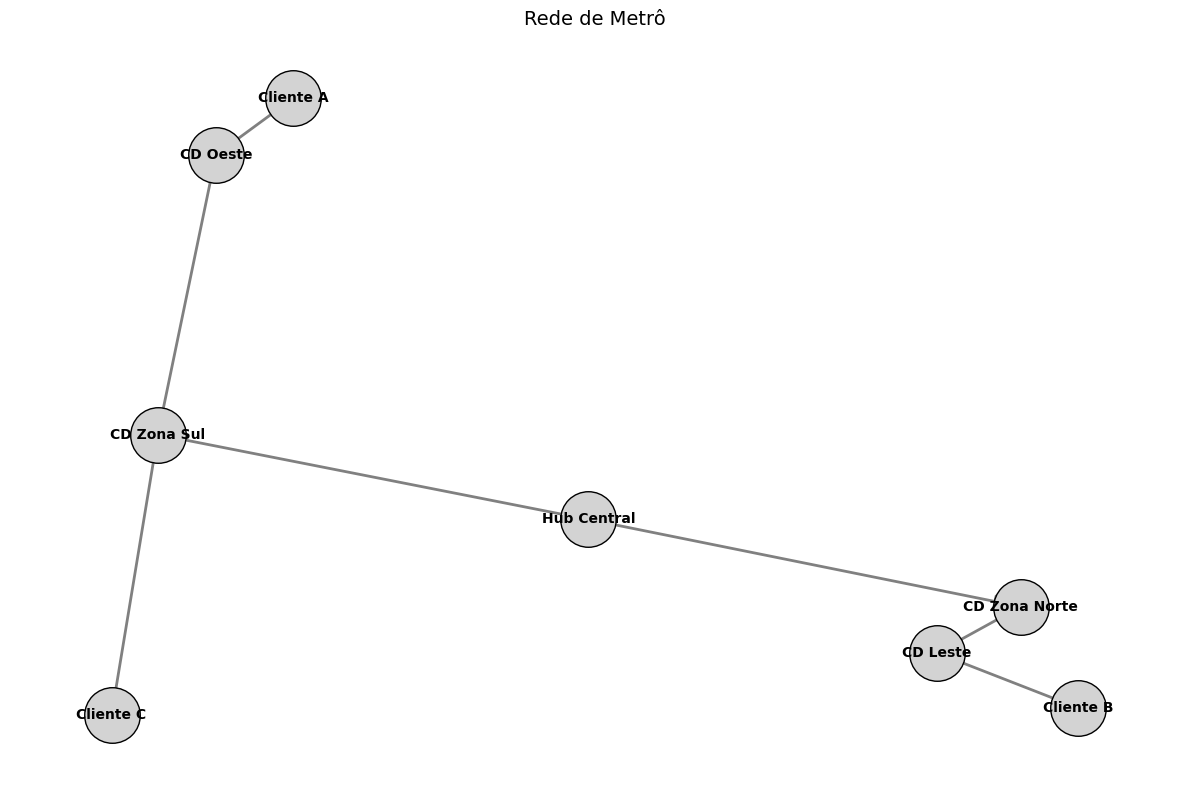

In [29]:
desenhar_grafo_subway(vertices,edges)

In [30]:
g = GraphFrame(vertices,edges)

In [31]:
shortest = g.shortestPaths(landmarks=['Cliente A', 'Cliente B', 'Cliente C'])

In [33]:
shortest.select("id", "distances" ).orderBy("id").show(truncate=False)

+-------------+------------------------------------------------+
|id           |distances                                       |
+-------------+------------------------------------------------+
|CD Leste     |{Cliente B -> 1}                                |
|CD Oeste     |{Cliente A -> 1}                                |
|CD Zona Norte|{Cliente B -> 2}                                |
|CD Zona Sul  |{Cliente A -> 2, Cliente C -> 1}                |
|Cliente A    |{Cliente A -> 0}                                |
|Cliente B    |{Cliente B -> 0}                                |
|Cliente C    |{Cliente C -> 0}                                |
|Hub Central  |{Cliente B -> 3, Cliente A -> 3, Cliente C -> 2}|
+-------------+------------------------------------------------+

